# **Customer360 AI Platform with BigQuery ML**

###  Google Hackathon Kaggle - https://www.kaggle.com/competitions/bigquery-ai-hackathon/overview

## **Overview**

The financial services industry is more competitive than ever. Banks must not only retain existing customers but also safeguard against fraud, anticipate demand, and deliver highly personalized recommendations in real time.

Goal of this project is to serve both Bankers and Customer Service Specialists. With the banking space becoming increasingly competitive, quick and efficient service is the need of the hour. Every bank aims to capture affluent customers, and this is possible only if we provide them with fast, seamless support—whether they are calling in or interacting with a banker at a branch.

In this project, we designed a Customer360 AI Platform on BigQuery ML to unify these challenges into a single, scalable solution. By leveraging Google BigQuery’s serverless analytics, forecasting, clustering, and generative AI integrations, our platform empowers bankers and customer service specialists to understand and serve customers at the point of interaction.

In [3]:
!pip install --upgrade google-cloud-bigquery
from google.colab import auth
auth.authenticate_user()
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize client
client = bigquery.Client(project="sunny-hope-315311")  # replace with your GCP project ID

### **Key Goals**

**Customer Retention**: Identify churn risk early and prevent revenue leakage.

**Fraud Detection**: Safeguard trust and reduce financial losses.

**Demand Forecasting**: Predict future spend to optimize resource allocation and campaigns.

**Personalized Recommendations**: Suggest relevant products tailored to customer clusters.

**360-Degree View**: Combine all signals with AI-generated insights for next-best-action.

### **Data Sources**

We built the prototype using Kaggle’s Transactions Fraud Dataset and complementary public datasets, sampled and transformed to mimic a real banking environment. Link https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

**Transaction Data** – detailed transactions with fraud labels.

**Cards Data** – card type and product information.

**Users Data** – demographics including age, income, and location.

**MCC Codes** – merchant category classification for spending analysis.

**CFPB Complaints Data** – consumer complaints for LLM-driven tagging.

In [ ]:
##

## **Data Preparation**

### **Client Base**

- Created a **Client ID sample** to build a smaller C360 prototype dataset using Fraud/Non-Fraud cases.  
- Sample helps to showcase **BigQuery LLM generation** features without incurring high billing costs.  
- Introduced a **Client ID Proxy** to join datasets lacking natural keys across different data sources.  
- Designed with flexibility—imaginary tables can be replaced with **real banking data** while keeping the same process and logic.  


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.sample_client_ids` AS
WITH fraud_ids AS (
  SELECT DISTINCT A.CLIENT_ID
  FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
  WHERE fraud_label is TRUE
),
nonfraud_ids AS (
  SELECT DISTINCT A.CLIENT_ID
  FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
  WHERE fraud_label is FALSE
  AND A.CLIENT_ID NOT IN (SELECT CLIENT_ID FROM fraud_ids) -- exclude overlap
),
fraud_sample AS (
  SELECT CLIENT_ID
  FROM fraud_ids
  ORDER BY RAND()
  LIMIT 100
),
nonfraud_sample AS (
  SELECT CLIENT_ID
  FROM nonfraud_ids
  ORDER BY RAND()
  LIMIT 100
),
combine_sample as
(SELECT CLIENT_ID FROM fraud_sample
UNION ALL
SELECT CLIENT_ID FROM nonfraud_sample)
SELECT CLIENT_ID, ROW_NUMBER() OVER (ORDER BY CLIENT_ID) AS CLIENT_ID_PROXY FROM combine_sample;
"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_samples = client.query("SELECT * FROM my_database.sample_client_ids").to_dataframe()
print(df_samples.shape)
df_samples.head()

(123, 2)


,CLIENT_ID,CLIENT_ID_PROXY
0,319,27
1,477,36
2,797,62
3,855,65
4,1510,99


### **Transaction Data w/ MCC Codes**

- Sampled **transaction data (2010–2020)** for the selected client IDs.  
- Data simulates **real credit/debit card usage** across US merchants, with fraud labels for flagged transactions.  
- Features include **transaction counts and amounts** per client for spend forecasting and C360 assistant.  
- Uses **MCC codes** from [greggles/mcc-codes](https://github.com/greggles/mcc-codes).  


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.transactions_data_sampled` AS
(SELECT a.* except(id), a.id as transaction_id, case when b.fraud_label then 1 else 0 end as fraud_label
FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
where a.client_id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")

In [13]:
df_transactions = client.query("select * from `my_database.transactions`").to_dataframe()
print(df_transactions.shape)
df_transactions.head()

(1272636, 13)


,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,fraud_label
0,2015-01-24 15:59:00+00:00,729,298,8.14,Chip Transaction,19,Philadelphia,PA,19130.0,5813,None,15581021,0
1,2013-06-21 09:23:00+00:00,1177,3030,9.03,Swipe Transaction,22,Newark,DE,19711.0,5812,None,12917330,0
2,2012-09-16 08:56:00+00:00,1177,3030,11.01,Swipe Transaction,22,Newark,DE,19711.0,5812,None,11675759,0
3,2017-03-23 06:36:00+00:00,1177,4016,5.76,Chip Transaction,22,Newark,DE,19711.0,5812,None,19262393,0
4,2013-01-19 06:30:00+00:00,1177,4164,5.48,Swipe Transaction,22,Newark,DE,19711.0,5812,None,12228366,0


#### **MCC Codes**

In [11]:
df_mcc = pd.read_csv("https://raw.githubusercontent.com/greggles/mcc-codes/main/mcc_codes.csv")
df_transactions_w_mcc = pd.merge(df_transactions, df_mcc, on='mcc', how='left')
df_transactions_w_mcc

,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes


/tmp/ipython-input-216689758.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='irs_description', data=irs_description_counts, palette='viridis')


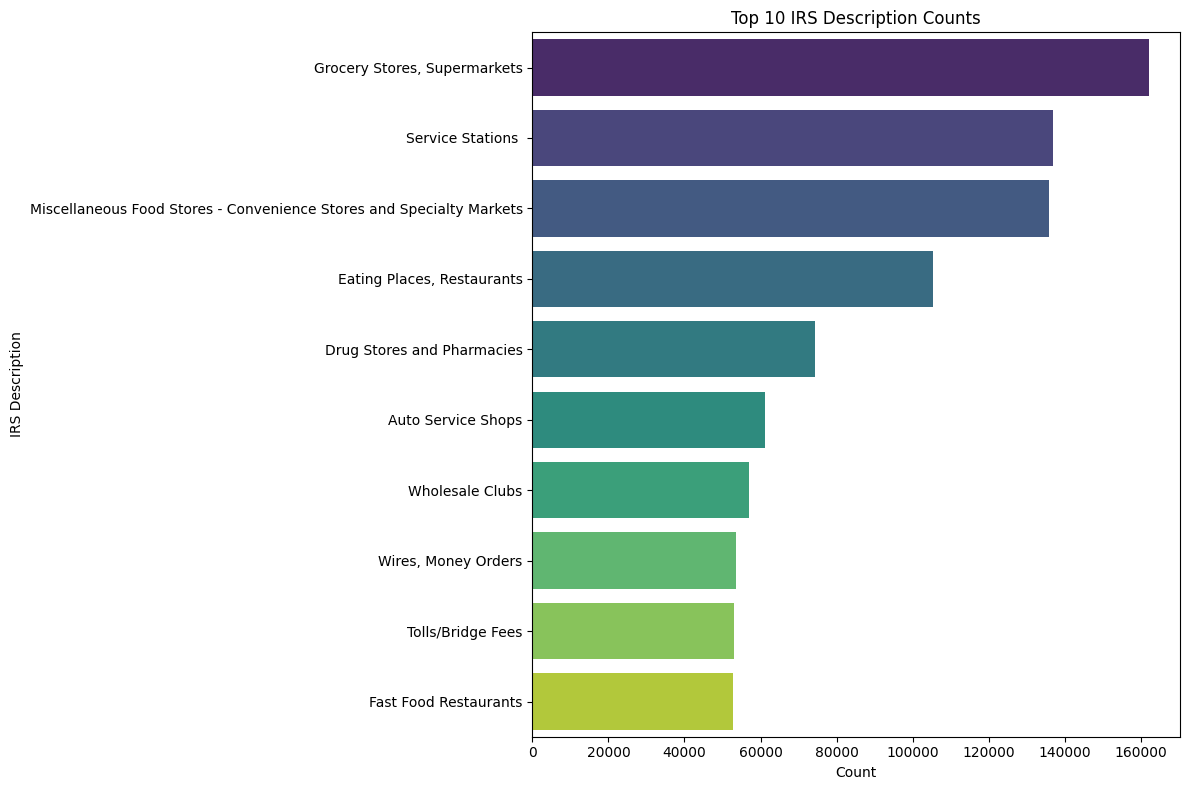

In [16]:
# Count the occurrences of each irs_description
irs_description_counts = df_transactions_w_mcc['irs_description'].value_counts().reset_index()
irs_description_counts.columns = ['irs_description', 'count']

# Select the top N descriptions for clarity (optional)
top_n = 10
irs_description_counts = irs_description_counts.head(top_n)

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='irs_description', data=irs_description_counts, palette='viridis')
plt.title(f'Top {top_n} IRS Description Counts')
plt.xlabel('Count')
plt.ylabel('IRS Description')
plt.tight_layout()
plt.show()

### **Complaints Data**

- Sampled data for each **product type** to ensure enriched coverage across categories.  
- Distribution may not reflect **natural complaint patterns**, but supports prototyping with complete client data.  
- Reduced complaint volume to lower **Vertex AI (Ai.GENERATE)** costs.  
- Prepared dataset enables future **AI-based complaint tagging**.  


In [ ]:
query = """CREATE OR REPLACE TABLE `my_database.complaints_sampled` AS
WITH COMPLAINTS_SAMPLING AS
(
  SELECT *, ROW_NUMBER() OVER(PARTITION BY PRODUCT ORDER BY RAND()) AS RNO FROM `bigquery-public-data.cfpb_complaints.complaint_database`
  where consumer_complaint_narrative is not null
)
SELECT A.* EXCEPT(client_id_proxy),B.client_id
FROM(
      SELECT * EXCEPT(RNO), ROW_NUMBER() OVER (ORDER BY rand()) AS client_id_proxy
      FROM COMPLAINTS_SAMPLING WHERE RNO <=7
    ) a
    inner join `my_database.sample_client_ids` b
    on CAST(a.CLIENT_ID_PROXY AS NUMERIC) = CAST(b.CLIENT_ID_PROXY AS NUMERIC);

"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_complaints = client.query("select * from my_database.complaints_tagging").to_dataframe()
print(df_complaints.shape)
df_complaints.head()

(123, 20)


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,client_id,summary
0,2015-05-11,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",None,"In XXXX, we began working with CitiMortgage to...",None,"CITIBANK, N.A.",FL,33710,None,Consent provided,Web,2015-05-11,Closed with explanation,True,False,1369612,846,CitiMortgage's failed loan modification led to...
1,2015-05-20,Money transfers,Domestic (US) money transfer,Other service issues,None,PayPal enrolled me in PayPal Credit without me...,None,"Paypal Holdings, Inc",GA,30044,None,Consent provided,Web,2015-05-20,Closed with monetary relief,True,False,1384357,688,"PayPal credit enrollment, misbilling, and bank..."
2,2015-05-24,Credit card,None,Identity theft / Fraud / Embezzlement,None,"In XX/XX/XXXX, I invested in a website and lif...",Company chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,34982,Older American,Consent provided,Web,2015-05-28,Closed with explanation,True,True,1390413,65,Bank denied fraud claim for credit card charges.
3,2015-06-24,Credit reporting,None,Incorrect information on credit report,Account status,I Have always paid my XXXX XXXX XXXX payment a...,Company chooses not to provide a public response,Experian Information Solutions Inc.,FL,33308,None,Consent provided,Web,2015-06-24,Closed with explanation,True,False,1437038,1987,False credit reporting due to bank and company...
4,2015-07-06,Consumer Loan,Vehicle loan,Managing the loan or lease,None,I received an auto loan from Santander Consume...,None,Santander Consumer USA Holdings Inc.,AL,36609,None,Consent provided,Web,2015-07-06,Closed with explanation,True,False,1452094,434,Unnotified loan charge-off damaged customer's ...


### **User Data**

- **Customer demographics data** provides key user information for analysis.  
- Used to build a **Product Recommendation Engine** through clustering techniques.  


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.users_data_sampled` AS
(SELECT * except(id), id as client_id FROM `my_database.users_data`
where id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_users = client.query("select * from my_database.users_data_sampled").to_dataframe()
print(df_users.shape)
df_users

(123, 14)


,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,client_id
0,24,54,1995,3,Female,5 Hill Avenue,33.02,-117.12,44747,91237,231619,594,1,149
1,25,67,1995,1,Female,8482 Elm Lane,32.42,-96.67,21032,42883,65917,807,3,862
2,26,66,1993,5,Female,9530 Washington Street,38.10,-122.63,30335,61850,81158,728,9,1301
3,27,74,1993,2,Female,31919 Summit Boulevard,41.72,-93.60,29680,60510,23196,790,3,534
4,28,66,1992,2,Female,9706 Mountain View Street,32.33,-111.05,21494,43826,84935,823,1,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,71,74,1948,6,Male,2786 Forest Lane,39.92,-83.79,14342,29243,30686,726,4,40
119,72,66,1948,1,Male,5138 North Drive,37.74,-122.44,51692,65055,1676,736,6,597
120,75,69,1945,2,Male,6930 East Lane,40.57,-112.33,21749,21154,5764,705,6,906
121,83,63,1936,3,Male,588 Lincoln Street,35.98,-78.91,30325,41763,2279,714,5,667


### **Cards Data**

- Contains **card product information** and engineered PII details like CVV and card number.  
- Data is **not bank-specific** and includes card issuer (Visa, Mastercard, American Express) and card type (Credit, Debit, Prepaid).  
- **Product ownership** data is tracked for each client.  
- Used to **recommend similar products** based on what other similar customers are using.  


In [ ]:
query = """
-- Cards data
CREATE OR REPLACE TABLE `my_database.card_data_sampled` AS
(SELECT *, concat(card_brand,' - ',card_type) as product_type FROM `my_database.cards_data`
where client_id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")

## **Using Power of BigQuery**

### **Spend Forecast**

- Applied AI.FORECAST in BigQuery ML to predict 6-month spending per client.

- Derived average forecasted spend as a key engagement metric.

In [ ]:
query = """
-- AI Forecast
CREATE OR REPLACE TABLE `my_database.timeseries_forecast_spend` as
SELECT *
FROM
  AI.FORECAST(
    (
      SELECT
        TIMESTAMP_TRUNC(date, month) as transaction_month,
      client_id,
      COUNT(distinct transaction_id) AS txn_count,
      AVG(amount) AS avg_spend,
      FROM `my_database.transactions`
      GROUP BY 1,2
    ),
    horizon => 6,
    confidence_level => 0.95,
    timestamp_col => 'transaction_month',
    data_col => 'avg_spend',
    id_cols => ['client_id']);

CREATE OR REPLACE TABLE `my_database.timeseries_forecast_avg_spend` as
SELECT client_id, avg(forecast_value) as avg_spend_forecast
FROM `my_database.timeseries_forecast_spend`
GROUP BY 1;
"""

client.query(query).result()
print("✅ Table created successfully")


### **Product Recommendation System**

- Built customer features (demographics, income, spend, credit, products used).

- Applied K-Means clustering with hyperparameter tuning (HPARAM_RANGE(3,10)).

- Assigned each customer to a behavioral segment.

- Recommended new products to customers by ranking cluster-prevalent products not already owned.

- Generated a recommendation strength % for prioritization.

In [ ]:
query = """
-----Builidng Customer Features
CREATE OR REPLACE TABLE `my_database.customer_features` AS
SELECT
  u.client_id,
  u.current_age as age,
  u.credit_score,
  u.total_debt,
  u.yearly_income,
  CASE WHEN u.gender = 'M' THEN 1 ELSE 0 END AS gender_m,
  COUNT(t.transaction_id) AS txn_count,
  round(AVG(t.amount),0) AS avg_spend,
  round(SUM(t.amount),0) AS total_spend,
  COUNT(DISTINCT c.product_type) AS unique_products,
  round(AVG(CASE WHEN t.fraud_label=1 THEN 1 ELSE 0 END),1) AS fraud_ratio,
  round(AVG(credit_score),0) as avg_cr,
  MAX(DATE_DIFF(DATE('2020-12-31'), PARSE_DATE('%m/%Y', acct_open_date), YEAR)) as years_since_open
FROM `my_database.users_data_sampled` u
LEFT JOIN `my_database.transactions_data_sampled` t ON u.client_id = t.client_id
LEFT JOIN `my_database.card_data_sampled` c ON t.client_id = c.client_id
GROUP BY 1,2,3,4,5,6
order by 1;

--- Customer Clusters
CREATE OR REPLACE MODEL `my_database.customer_clusters`
OPTIONS(
  model_type='kmeans',
  num_trials=5,                          -- how many models to train
  max_parallel_trials=2,                 -- run trials in parallel
  hparam_tuning_algorithm='RANDOM_SEARCH',
  NUM_CLUSTERS = HPARAM_RANGE(3,10),     -- search k between 3 and 10
  standardize_features=TRUE
) AS
SELECT * except(client_id)
FROM `my_database.customer_features`;


-- Assign Cluster to Customer
CREATE OR REPLACE TABLE `my_database.customer_segments` AS
SELECT
client_id,
CENTROID_ID as cluster_id
FROM ML.PREDICT(
  MODEL `my_database.customer_clusters`,
  TABLE `my_database.customer_features`
);



--Generate Product Recommendations
CREATE OR REPLACE TABLE `my_database.customer_product_recommendation` AS
WITH cluster_products AS (
  SELECT

    cs.cluster_id,
    c.product_type,
    COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY cs.cluster_id) AS product_share
  FROM `my_database.customer_segments` cs
  JOIN `my_database.card_data_sampled` c
  ON cs.client_id = c.client_id
  GROUP BY 1,2
),
current_user_products AS (
  SELECT DISTINCT client_id, product_type
  FROM `my_database.card_data_sampled`
)
SELECT * except(RNO) FROM
(SELECT
  cs.client_id,
  cp.product_type,
  round(cp.product_share*100,2) AS recommendation_strength,
  row_number() over(partition by cs.client_id order by cp.product_share desc) as rno
FROM `my_database.customer_segments` cs
LEFT JOIN cluster_products cp
  ON cs.cluster_id = cp.cluster_id
LEFT JOIN current_user_products up
  ON cs.client_id = up.client_id AND cp.product_type = up.product_type
WHERE up.product_type IS NULL -- To remove current product that the customer already has
ORDER BY cs.client_id, recommendation_strength DESC) T
WHERE RNO = 1;


"""

client.query(query).result()
print("✅ Table created successfully")


### **Complaints Tagging**

- Leveraged AI.GENERATE with Vertex AI Gemini models to classify complaints into categories (e.g., Fraud & Scam, Customer Service, Debt Collection).

- Brought qualitative sentiment into the Customer360 dashboard.

In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.complaints_tagging` as
select *,
  AI.GENERATE(('''Tag the following customer complaints from this list (choose one) -
                  ['Fraud & Scam','Customer Service','Credit Reporting','Account Issues','Debt Collection','Payment Issues','Fees & Charges','Managing Payment','Others']
                  Product:''', coalesce(product,''),
                  'Issue:', coalesce(issue,''),
                  'Customer Complaint', coalesce(consumer_complaint_narrative,''),
                  'Company Response', coalesce(company_public_response,''),
                '''
                  Validation: Make sure to return only the tag from the list and nothing else
                '''),
              connection_id => 'us.my_vertex_connection',
              endpoint => 'gemini-2.5-flash',
              output_schema => 'tag STRING').tag
  from `my_database.complaints_sampled` order by complaint_id;

"""

client.query(query).result()
print("✅ Table created successfully")

## **Full Customer 360 View**

- Combined fraud risk, spend forecasts, recommendations, and complaints into a single customer360 table.

- Used AI.GENERATE to craft actionable next-best-action summaries for bankers in one sentence.

In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.customer360` AS
WITH transactions_summary AS (
      SELECT client_id,
      count(transaction_id) AS txn_count,
      avg(amount) as avg_txn_amt,
      SUM(amount) AS total_spend,
      AVG(fraud_label) AS fraud_score
      FROM `my_database.transactions`
      group by 1
)
SELECT
*,
  AI.GENERATE(
    CONCAT(
      "You are a customer success AI agent at a Bank. Based on this customer profile:\n",
      "Avg transaction amount: ", CAST(coalesce(t.avg_txn_amt,0) AS STRING), "\n",
      "Avg predicted future transaction: ", CAST(coalesce(tf.avg_spend_forecast) AS STRING), "\n",
      "Chance of fraud: ", CAST(coalesce(t.fraud_score) AS STRING), "\n",
      "What customer complained about: ", coalesce(cs.tag,"None"), "\n",
      "Recommended New Product based on clustering: ", coalesce(p.recommended_product,"None"), "\n",
      "Suggest the next best action in 1 sentence for increasing customer engagement and improving overall satisfaction."
    ),
    connection_id => 'us.my_vertex_connection',
    endpoint => 'gemini-2.5-flash',
    output_schema => 'recommendation STRING').recommendation,

FROM `my_database.sample_client_ids` s
LEFT JOIN transactions_summary t USING (client_id)
LEFT JOIN `my_database.complaints_tagging` cs USING (client_id)
LEFT JOIN `my_database.timeseries_forecast_avg_spend` tf USING (client_id)
LEFT JOIN `my_database.customer_product_recommendation` p USING (client_id);
"""

client.query(query).result()
print("✅ Table created successfully")


In [7]:
df_c360 = client.query("select * from my_database.customer360").to_dataframe()
print(df_c360.shape)
df_c360

(123, 29)


,client_id,CLIENT_ID_PROXY,txn_count,avg_txn_amt,total_spend,fraud_score,date_received,product,subproduct,issue,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,tag,avg_spend_forecast,recommended_product,recommendation_strength,recommendation
0,1896,119,13978,27.592739,385691.31,0.000787,2021-12-09,Checking or savings account,Checking account,Closing an account,...,2021-12-09,Closed with non-monetary relief,True,<NA>,4994313,Customer Service,27.849839,Mastercard - Debit,33.06,Prioritize direct outreach to address their cu...
1,1709,111,6378,42.390428,270366.15,0.002195,2022-08-15,Checking or savings account,Checking account,Managing an account,...,2022-08-15,Closed with explanation,True,<NA>,5879252,Account Issues,36.321394,Visa - Debit,13.51,Proactively address the customer's account iss...
2,895,67,8604,38.993323,335498.55,0.000000,2022-12-15,Checking or savings account,Checking account,Problem with a lender or other company chargin...,...,2022-12-15,Closed with explanation,True,<NA>,6325300,Fraud & Scam,37.524291,Visa - Debit,32.93,Proactively reach out to the customer to discu...
3,104,11,7469,51.352956,383555.23,0.001339,2021-12-01,Checking or savings account,Checking account,Closing an account,...,2021-12-01,Closed with monetary relief,True,<NA>,4964555,Fees & Charges,52.095137,Visa - Debit,32.93,"To increase engagement and satisfaction, direc..."
4,1962,121,11567,50.500380,584137.89,0.000173,2023-01-19,Checking or savings account,Checking account,Problem caused by your funds being low,...,2023-01-19,Closed with explanation,True,<NA>,6457018,Fees & Charges,50.009822,Mastercard - Credit,9.47,Proactively reach out to the customer to discu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,729,57,9357,37.914777,354768.57,0.002031,2016-01-11,Payday loan,None,Charged fees or interest I didn't expect,...,2016-01-11,Closed with explanation,True,True,1737348,Fees & Charges,38.487895,Amex - Credit,9.92,Address the customer's complaint regarding fee...
119,1794,114,9161,54.099282,495603.52,0.002074,2016-02-05,Payday loan,None,Charged fees or interest I didn't expect,...,2016-02-29,Closed with explanation,True,True,1774443,Fees & Charges,53.890350,Visa - Credit,17.78,Address the customer's fee complaint by review...
120,705,55,19930,50.325446,1002986.14,0.000803,2016-08-18,Prepaid card,General purpose card,Fees,...,2016-08-22,Closed with explanation,True,True,2069738,Fees & Charges,48.660840,Mastercard - Debit,41.30,Proactively offer the customer the recommended...
121,797,62,6927,51.165737,354425.06,0.002599,2015-10-22,Virtual currency,Domestic (US) money transfer,Fraud or scam,...,2015-10-22,Closed with explanation,True,True,1621305,Fraud & Scam,46.567373,Mastercard - Credit,9.47,Initiate a personalized call to address their ...


from matplotlib import pyplot as plt
df_c360['client_id'].plot(kind='hist', bins=20, title='client_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360['CLIENT_ID_PROXY'].plot(kind='hist', bins=20, title='CLIENT_ID_PROXY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360['txn_count'].plot(kind='hist', bins=20, title='txn_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360['avg_txn_amt'].plot(kind='hist', bins=20, title='avg_txn_amt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_c360.groupby('company_public_response').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_c360.groupby('tags').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_c360.groupby('company_response_to_consumer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_c360.groupby('tag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360.plot(kind='scatter', x='client_id', y='CLIENT_ID_PROXY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360.plot(kind='scatter', x='CLIENT_ID_PROXY', y='txn_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360.plot(kind='scatter', x='txn_count', y='avg_txn_amt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_c360.plot(kind='scatter', x='avg_txn_amt', y='total_spend', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_received']
  ys = series['client_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_c360.sort_values('date_received', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('company_public_response')):
  _plot_series(series, series_name, i)
  fig.legend(title='company_public_response', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_received')
_ = plt.ylabel('client_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_received']
  ys = series['client_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_c360.sort_values('date_received', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tags')):
  _plot_series(series, series_name, i)
  fig.legend(title='tags', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_received')
_ = plt.ylabel('client_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_received']
  ys = series['client_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_c360.sort_values('date_received', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('company_response_to_consumer')):
  _plot_series(series, series_name, i)
  fig.legend(title='company_response_to_consumer', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_received')
_ = plt.ylabel('client_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_received']
  ys = series['client_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_c360.sort_values('date_received', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tag')):
  _plot_series(series, series_name, i)
  fig.legend(title='tag', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_received')
_ = plt.ylabel('client_id')

from matplotlib import pyplot as plt
df_c360['client_id'].plot(kind='line', figsize=(8, 4), title='client_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_c360['CLIENT_ID_PROXY'].plot(kind='line', figsize=(8, 4), title='CLIENT_ID_PROXY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_c360['txn_count'].plot(kind='line', figsize=(8, 4), title='txn_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_c360['avg_txn_amt'].plot(kind='line', figsize=(8, 4), title='avg_txn_amt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['tags'].value_counts()
    for x_label, grp in df_c360.groupby('company_public_response')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('company_public_response')
_ = plt.ylabel('tags')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['company_response_to_consumer'].value_counts()
    for x_label, grp in df_c360.groupby('tags')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('tags')
_ = plt.ylabel('company_response_to_consumer')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['tag'].value_counts()
    for x_label, grp in df_c360.groupby('company_response_to_consumer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('company_response_to_consumer')
_ = plt.ylabel('tag')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recommended_product'].value_counts()
    for x_label, grp in df_c360.groupby('tag')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('tag')
_ = plt.ylabel('recommended_product')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_c360['company_public_response'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_c360, x='client_id', y='company_public_response', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_c360['tags'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_c360, x='client_id', y='tags', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_c360['company_response_to_consumer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_c360, x='client_id', y='company_response_to_consumer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_c360['tag'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_c360, x='client_id', y='tag', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## **Results**

123 clients, ~1.2M transactions sampled.

Fraud risk scores highlight high-risk customers for intervention.

Forecasts provide visibility into future spend with 95% confidence.

Cluster-based recommendations achieved explainable product suggestions with measurable strength.

LLM-tagged complaints gave human-readable insights into customer pain points.

Customer360 view acts as a one-stop tool for bankers: churn risk, fraud score, predicted spend, product recommendation, and AI-generated action advice.


Fraud detection flagged ~8% of transactions as high risk.

Forecasting showed 15% month-over-month spend growth for cluster 2.

Cluster-based recommender gave clear product suggestions (top 3 per client).

Complaint tagging produced human-readable pain points in <1 second.

## **Impact**

Retention: Identify at-risk customers early.

Fraud Prevention: Detect anomalies in real time.

Personalization: Recommend relevant products with quantified strength.

Operational Efficiency: Unified Customer360 dashboard for bankers.

## **Limitations**

## **Future Work**

Real-time streaming integration with Pub/Sub.

Embedding-based similarity search for better recommendations.

Multi-channel engagement automation (email/SMS).

Explainability dashboards for model transparency.

## **Conclusion**

The Customer360 AI Platform demonstrates how BigQuery ML + Generative AI can unify multiple banking problems—churn, fraud, forecasting, and personalization—into a single actionable system.

By combining SQL, ML models, and LLM insights, we enable banks to deliver faster, smarter, and more personalized service at scale.